In [1]:
import os 
input_dir = 'C:/Users/oceanlightai/Desktop/datasets/pet_skin/train/train_image2'
target_dir = 'C:/Users/oceanlightai/Desktop/datasets/pet_skin/train/train_mask2'
img_size = (160,160)
num_classes = 7
batch_size = 64

input_img_paths = sorted([os.path.join(input_dir,fname)
                         for fname in os.listdir(input_dir)
                         if fname.endswith('.jpg')])

target_img_paths = sorted([os.path.join(target_dir,fname)
                         for fname in os.listdir(target_dir)
                         if fname.endswith('.jpg') and not fname.startswith('.')])


C:\Users\oceanlightai\anaconda3\envs\gpu\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\oceanlightai\anaconda3\envs\gpu\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
C:\Users\oceanlightai\anaconda3\envs\gpu\lib\site-packages\numpy\.libs\libopenblas.XWYDX2IKJW2NMTWSFYNGFUWKQU3LYTCZ.gfortran-win_amd64.dll
  stacklevel=1)


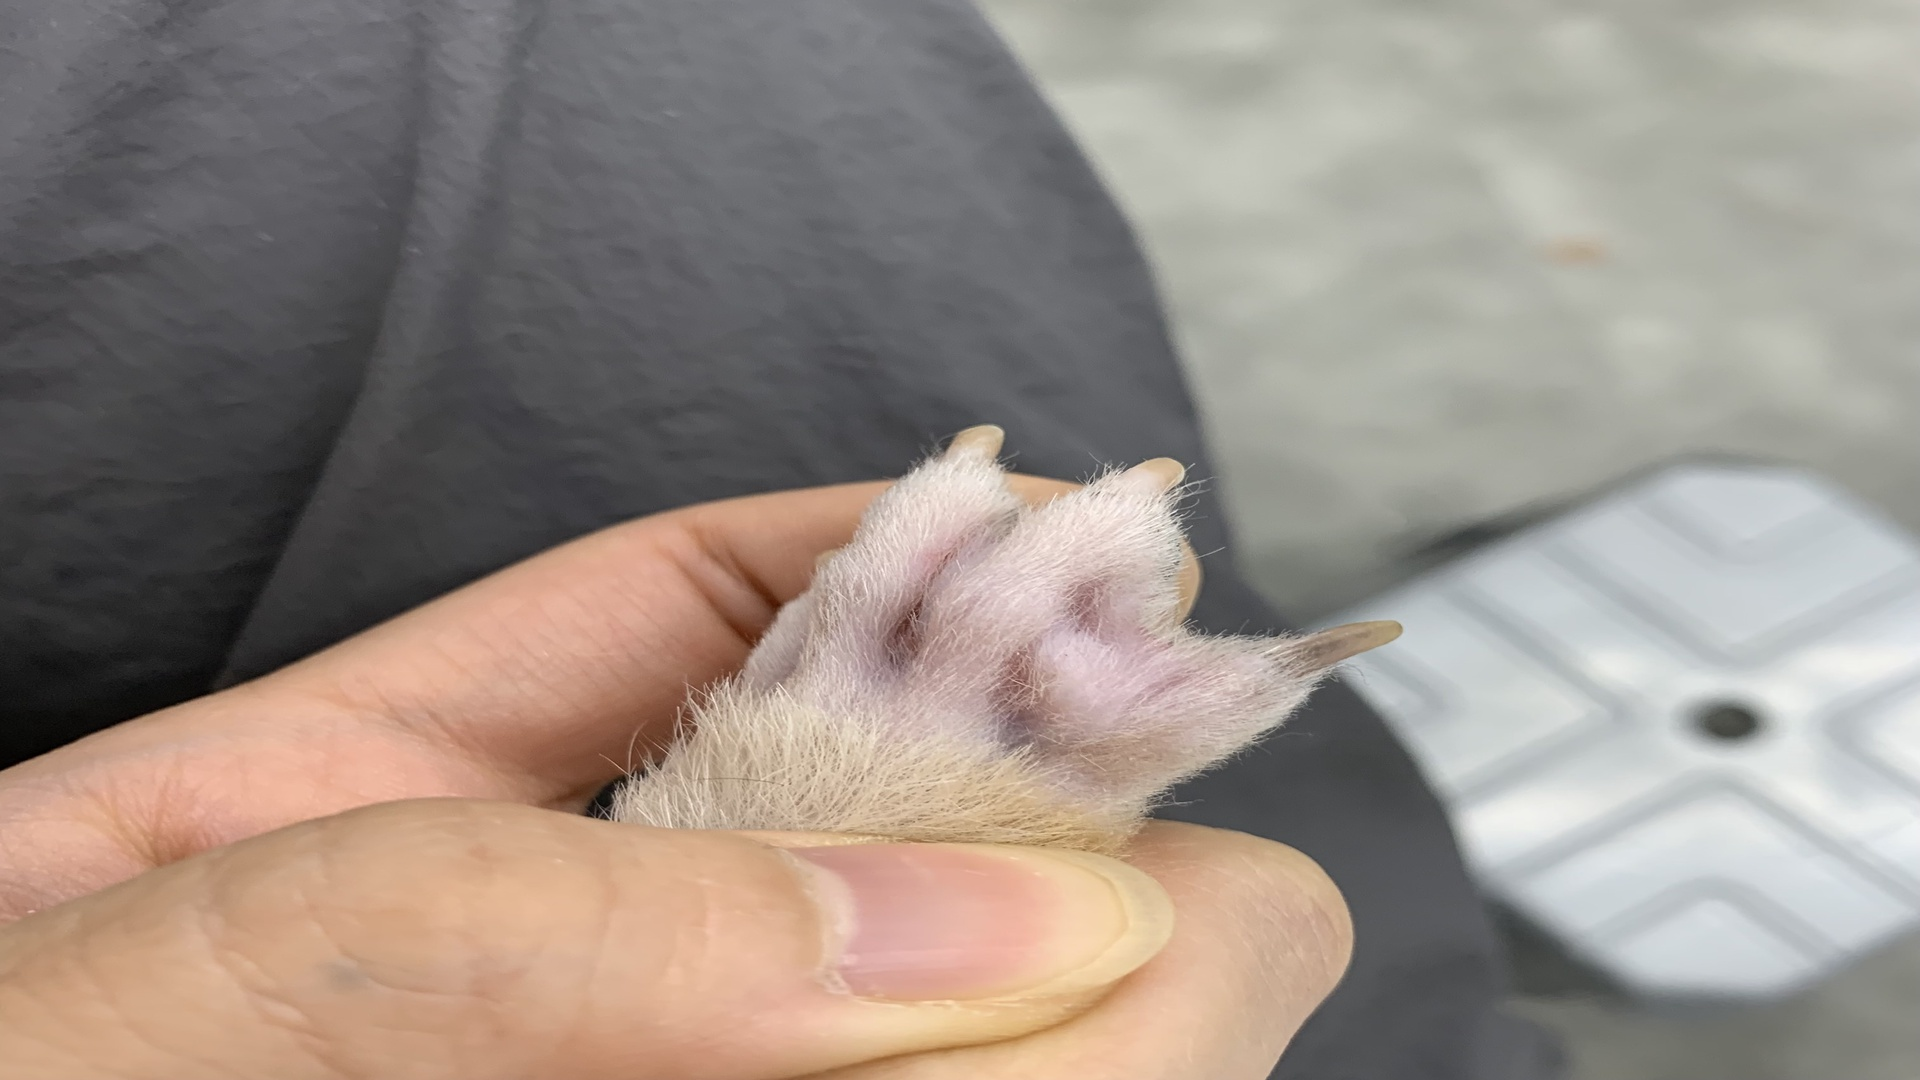

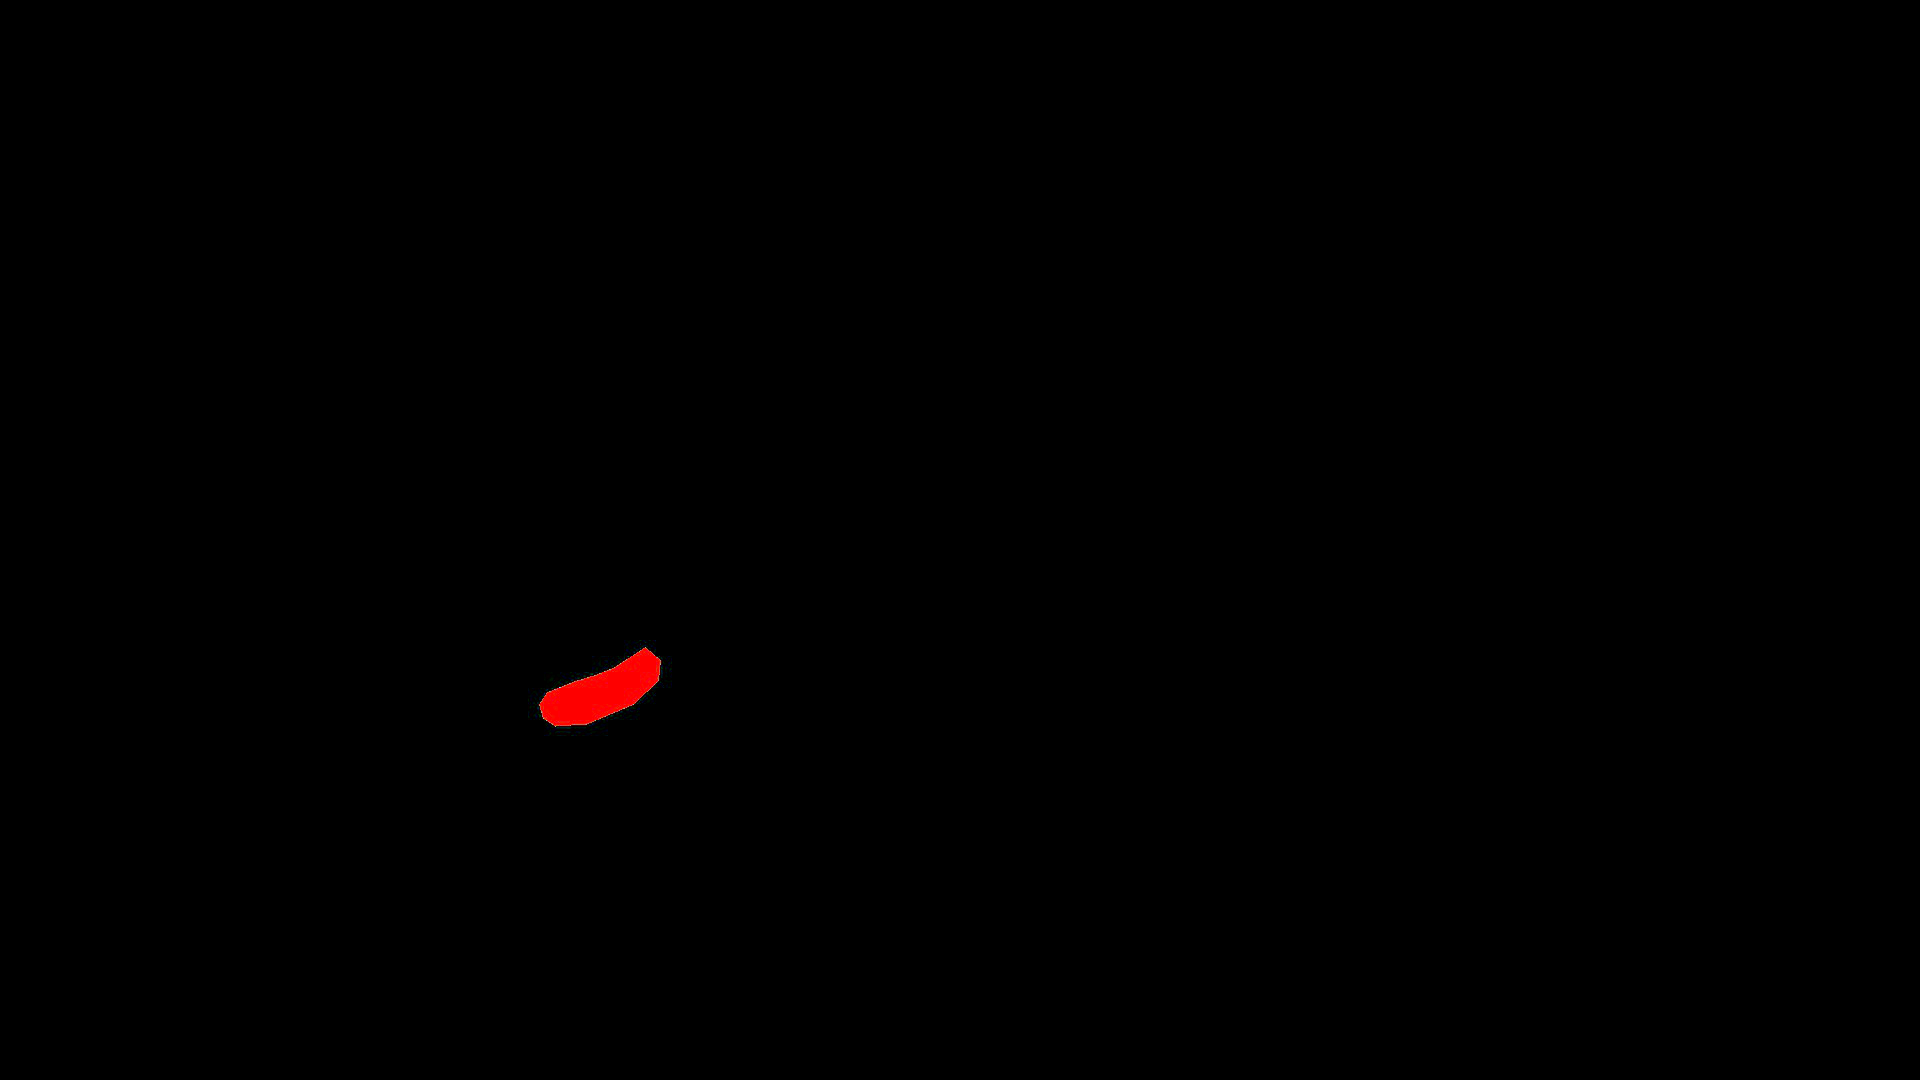

In [2]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
from PIL import ImageOps

display(Image(filename=input_img_paths[7]))
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[7]))
display(img)

In [3]:
import numpy as np 
from tensorflow import keras 

class SkinDiseaseDataset(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths 
        
    def __len__(self):
        return len(self.target_img_paths) // self.batch_size
    
    def __getitem__(self, idx):
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i:i+self.batch_size]
        batch_target_img_paths = self.target_img_paths[i:i+self.batch_size]
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype='float32')
        for j, path in enumerate(batch_input_img_paths):
            img = load_img(path, target_size=self.img_size)
            x[j] = np.array(img) / 255.  # input normalization
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype='uint8')
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode='grayscale')
            y[j] = np.expand_dims(np.array(img), 2)  # removed y[j] -= 1
        return x, y

In [4]:
import random 
val_samples = 900
random.Random(1337).shuffle(input_img_paths)
random.Random(1337).shuffle(target_img_paths)

train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]
val_input_img_paths = input_img_paths[:-val_samples:]
val_target_img_paths = target_img_paths[:-val_samples:]

train_gen = SkinDiseaseDataset(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = SkinDiseaseDataset(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [5]:
from tensorflow.keras import layers 

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))
    
    x = layers.Conv2D(32, 3, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    
    previous_block_activation = x 
    
    for filters in [64, 128, 256]:
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation('relu')(x)
        x = layers.SeparableConv2D(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
        
        residual = layers.Conv2D(filters, 1, strides=2, padding='same')(previous_block_activation)
        x = layers.add([x, residual])
        previous_block_activation = x
        
    for filters in [256, 128, 64, 32]:
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.Activation('relu')(x)
        x = layers.Conv2DTranspose(filters, 3, padding='same')(x)
        x = layers.BatchNormalization()(x)
        
        x = layers.UpSampling2D(2)(x)
        
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding='same')(residual)
        x = layers.add([x, residual])
        previous_block_activation = x 
        
    outputs = layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(x)
    
    model = keras.Model(inputs, outputs)
    return model

In [6]:
model = get_model(img_size, num_classes)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 80, 80, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 80, 80, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 80, 80, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy')

callbacks = [keras.callbacks.ModelCheckpoint('Unet_segmentation.h5', save_best_only=True)]

epochs = 30

In [ ]:
model.fit(train_gen, epochs=epochs, validation_data=val_gen, callbacks=callbacks)

Epoch 1/30
49/79 [=================>............] - ETA: 1:29 - loss: nan

# 추론

In [ ]:
val_preds = model.predict(val_gen)

def display_mask(i):
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOpes.autocontrast(keras.preprocessing.image.array_toimg(mask))
    display(img)
    
i = 20

display(Image(filename=val_input_img_paths[i]))
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)
display_mask(i)
